In [548]:
import requests
import joblib
import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from pandas import option_context
from tqdm import tqdm
from statsmodels.stats.inter_rater import aggregate_raters
from sklearn.metrics import cohen_kappa_score
from scipy.stats import mannwhitneyu,shapiro,ttest_ind

import cliffsDelta as cd
import GenerateActivities as gat
import important_features as imf

In [549]:
QUERY_ROOT = "https://api.github.com"
TOKEN = '' # write your GitHub API key here
with open("token") as f:
    TOKEN = f.read().strip()
HEADERS={'Authorization':'token '+TOKEN}

## Section 3

### Question 1

#### Write an automated Python script to identify all GitHub bot actors in the list of contributors, by querying the GitHub REST API users endpoint and extracting the required information to make this decision. 

#### More information: You can search for the "type" key in the obtianed JSON result, If it is "Bot", then it is a bot actor, if it is "User", then it is an account.

In [550]:
# 1. Read the given <sample>.csv file into a pandas DataFrame (df).
# 2. Make sure there are 2 columns, one column name is "contributor" that has the name of the contributor, 
#    and another column name is "bothunter_type" that you will use later on in this assignment.
# 3. Display the DataFrame.
df = pd.DataFrame()
with open("Contributors/sample17.csv") as f:
    df = pd.read_csv(f)
print(df.head())


        contributor bothunter_type
0            Cadair          Human
1      HumphreyYang          Human
2  JuliaRegistrator            Bot
3           MridulS          Human
4          SobhanMP          Human


In [551]:
# 1. Store the names of the contributors in a list
# 2. print the list

contributors = df['contributor'].tolist()
print(contributors)

['Cadair', 'HumphreyYang', 'JuliaRegistrator', 'MridulS', 'SobhanMP', 'Zentrik', 'andy-sweet', 'baszalmstra', 'bioc-issue-bot', 'bryevdv', 'chainer-ci', 'codecov[bot]', 'codspeed-hq[bot]', 'commit-0', 'coveralls', 'd-v-b', 'dependabot[bot]', 'ecodiv', 'editorialbot', 'galaxyproject-sentryintegration[bot]', 'gandhis1', 'github-merge-queue[bot]', 'hobu', 'imagesc-bot', 'jbusecke', 'joshmoore', 'kelvinou01', 'lpsinger', 'matthewfeickert', 'meeseeksmachine', 'mmore500', 'nhz2', 'pascoec', 'pre-commit-ci[bot]', 'rabernat', 'renovate[bot]', 'santikka', 'steffilazerte', 'travishathaway', 'yabellini']


In [552]:
# 1. Using a for loop, iterate over each contributor in the list and query the GitHub Users API.
#    You can use "query = f'{QUERY_ROOT}/users/{contributor}'", where QUERY_ROOT is defined at the beginning of this notebook 
#    and 'contributor' is each individual contributor from the list
# 2. Get the response using 'response = requests.get(query, headers=HEADERS)'.
# 3. convert the response to JSON using 'json_response = response.json()'.
# 4. Iterate over each JSON response and get the value of the 'type' key. If it is "Bot" then the contributor is a bot actor, 
#    if "User" then the contributor is an account. You should boolean values to indicate if the contributor is a bot actor (True) or User/Organisation (False)
# 5. Save these results in list of dictionary of the form [{'contributor': <contributor name>, 'app': <boolean value>}, {...}, {...}, {...}].
#    Lets call this list as "app_dict"
# 6. Finally convert this list of dictionary to DataFrame by writing 'pd.DataFrame.from_dict(app_dict)'
# 7. Display the DataFrame. This should have two columns - contributor and app
app_dict = []
for contributor in contributors:
    query = f'{QUERY_ROOT}/users/{contributor}'
    response = requests.get(query, headers=HEADERS)
    json_response = response.json()
    if json_response['type'] == 'Bot':
        app_dict.append({'contributor': contributor, 'actor': True})
    else:
        app_dict.append({'contributor': contributor, 'actor': False})
    app_df = pd.DataFrame.from_dict(app_dict)
print(app_df)



                             contributor  actor
0                                 Cadair  False
1                           HumphreyYang  False
2                       JuliaRegistrator  False
3                                MridulS  False
4                               SobhanMP  False
5                                Zentrik  False
6                             andy-sweet  False
7                            baszalmstra  False
8                         bioc-issue-bot  False
9                                bryevdv  False
10                            chainer-ci  False
11                          codecov[bot]   True
12                      codspeed-hq[bot]   True
13                              commit-0  False
14                             coveralls  False
15                                 d-v-b  False
16                       dependabot[bot]   True
17                                ecodiv  False
18                          editorialbot  False
19  galaxyproject-sentryintegration[bot]

### Question 2

#### Add a new 'actor' column in the CSV file to store this information. You can write True if it is a bot actor and False if it is not.

#### Report on the total number of GitHub bot actors, and User accounts present in the list of accounts of your dataset.

In [553]:
# Merge the app DataFrame to df by writing 'pd.merge(df, <app df>, on='contributor'). This is similar to SQL join on primary key 'contributor'.
# The resultant df should have 3 columns - contributor, bothunter_type and user_type.

df = pd.merge(df, app_df, on='contributor')
print(df)

                             contributor bothunter_type  actor
0                                 Cadair          Human  False
1                           HumphreyYang          Human  False
2                       JuliaRegistrator            Bot  False
3                                MridulS          Human  False
4                               SobhanMP          Human  False
5                                Zentrik          Human  False
6                             andy-sweet          Human  False
7                            baszalmstra          Human  False
8                         bioc-issue-bot            Bot  False
9                                bryevdv          Human  False
10                            chainer-ci            Bot  False
11                          codecov[bot]            Bot   True
12                      codspeed-hq[bot]            Bot   True
13                              commit-0          Human  False
14                             coveralls            Bot

### Question 3

#### For each bot actor, write their purpose, the task that they automate by looking at their GitHub profile, homepage, information on the GitHub Marketplace, or other documentation that you can find online.


In [554]:
"""
1. codecov[bot]
   - Purpose: Automates the process of uploading code coverage reports to Codecov, a platform that provides code coverage insights.
   - Automated Task: Uploads coverage reports from continuous integration (CI) workflows to Codecov, facilitating the analysis of code coverage metrics.
   - Github: https://github.com/codecov/codecov-action

2. codspeed-hq[bot]
   - Purpose: Integrates performance benchmarking into development and CI workflows to detect regressions and optimize code performance.
   - Automated Task: Gathers performance data during CI processes to identify and address performance regressions.
   - Github: https://github.com/CodSpeedHQ

3. dependabot[bot]
   - Purpose: Maintains up-to-date and secure dependencies within a codebase by automating dependency updates.
   - Automated Task: Monitors dependencies for new versions and security vulnerabilities, automatically generating pull requests to update them.
   - Github: https://github.com/dependabot

4. galaxyproject-sentryintegration[bot]
   - Purpose: Enhances error monitoring by integrating test coverage data into Sentry's stack traces.
   - Automated Task: Provides insights into test coverage within Sentry, helping developers identify untested code that may cause errors.
   - Github: https://docs.sentry.io/product/codecov/

5. github-merge-queue[bot]
   - Purpose: Manages and automates the merging of pull requests in a controlled and efficient manner.
   - Automated Task: Queues and merges pull requests based on predefined conditions, ensuring a smooth integration process.
   - Github: https://github.com/apps/merge-queue-bot

6. pre-commit-ci[bot]
   - Purpose: Ensures code quality by automatically running pre-commit hooks on code changes.
   - Automated Task: Executes pre-commit hooks in CI environments, verifying code formatting, linting, and other checks before changes are merged.
   - Github: https://github.com/marketplace/pre-commit-ci

7. renovate[bot]
   - Purpose: Automates dependency management by keeping dependencies up-to-date and secure.
   - Automated Task: Scans for outdated dependencies and opens pull requests to update them, similar to Dependabot.
    - Github: https://github.com/renovatebot/renovate
"""

"\n1. codecov[bot]\n   - Purpose: Automates the process of uploading code coverage reports to Codecov, a platform that provides code coverage insights.\n   - Automated Task: Uploads coverage reports from continuous integration (CI) workflows to Codecov, facilitating the analysis of code coverage metrics.\n   - Github: https://github.com/codecov/codecov-action\n\n2. codspeed-hq[bot]\n   - Purpose: Integrates performance benchmarking into development and CI workflows to detect regressions and optimize code performance.\n   - Automated Task: Gathers performance data during CI processes to identify and address performance regressions.\n   - Github: https://github.com/CodSpeedHQ\n\n3. dependabot[bot]\n   - Purpose: Maintains up-to-date and secure dependencies within a codebase by automating dependency updates.\n   - Automated Task: Monitors dependencies for new versions and security vulnerabilities, automatically generating pull requests to update them.\n   - Github: https://github.com/depe

## Section 4

### Question 1

#### Write an automated script to use BIMBAS (Bot Identification Model Based on Activity Sequences) to obtain a prediction of the GitHub contributor type (Bot or Human) for the contributors present in your dataset.

#### Folow the steps given in each cell to use BIMBAS and obtain predictions.

### Read all the events and select the events performed by the contributors present in the given set

In [555]:
# 1. Read the csv file of events (all_events.csv) provided along with this notebook
# 2. Convert created_at column to datetime format 
#    One possible way is to use lambda function: "events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))"
# 3. Get the contributors provided to you in a list or use the contributors list that you created in Section 3 Question 1. 
#    e.g., ['contributor1', 'contributor2', 'contributor3',...]
# 4. Select the events performed by these contributors alone. Do not consider all the events. You should consider only the events
#    performed by the contributors provided to you. Hint: you can use the df.query function
# 5. Display the considered events.

events = pd.read_csv("all_events.csv")
events = events.assign(created_at=lambda d: pd.to_datetime(d.created_at, unit='ms'))
contributors_list = df['contributor'].tolist()
selected_events = events.query('login in @contributors_list')
selected_events


,Unnamed: 0,event_id,event_type,login,repository,created_at,action,PR_number,state,PR_node_id,...,comment_node_id,merged,ref,ref_type,issue_number,issue_node_id,issue_closed_at,tag_name,release_node_id,org
3,3,39747379822,IssueCommentEvent,codecov[bot],napari/napari,2024-07-01 00:00:10,created,7043.0,open,PR_kwDOCJ0aI85z_6lX,...,IC_kwDOCJ0aI86DDzXh,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,napari
163,163,39747766396,CreateEvent,dependabot[bot],SciML/EasyModelAnalysis.jl,2024-07-01 00:34:53,NaN,NaN,NaN,NaN,...,NaN,NaN,dependabot/github_actions/actions/add-to-proje...,branch,NaN,NaN,NaN,NaN,NaN,SciML
164,164,39747766717,PullRequestEvent,dependabot[bot],SciML/EasyModelAnalysis.jl,2024-07-01 00:34:55,opened,261.0,open,PR_kwDOI1YYHs50AC5Y,...,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SciML
233,233,39747944271,PullRequestReviewEvent,bryevdv,bokeh/bokeh,2024-07-01 00:49:02,created,13956.0,open,PR_kwDOADqB3M5z_le_,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,bokeh
321,321,39748383334,IssueCommentEvent,HumphreyYang,QuantEcon/lecture-python-intro,2024-07-01 01:20:39,created,NaN,open,NaN,...,IC_kwDOIy5DFs6DEAU4,NaN,NaN,NaN,470.0,I_kwDOIy5DFs6NhKkq,NaN,NaN,NaN,QuantEcon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358385,358385,42415261485,CommitCommentEvent,JuliaRegistrator,SciML/LineSearch.jl,2024-09-30 23:21:33,NaN,NaN,NaN,NaN,...,CC_kwDOLCAB0M4IyT9_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SciML
358388,358388,42415267981,PushEvent,pre-commit-ci[bot],spyder-ide/langchain-provider,2024-09-30 23:22:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,spyder-ide
358397,358397,42415358855,IssueCommentEvent,codspeed-hq[bot],conda/conda,2024-09-30 23:27:57,created,14285.0,open,PR_kwDOAF8kJs59LhsL,...,IC_kwDOAF8kJs6OHzZU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,conda
358398,358398,42415372311,IssueCommentEvent,codecov[bot],pybamm-team/PyBaMM,2024-09-30 23:28:49,created,4477.0,closed,PR_kwDOCUVVSc59LeQ9,...,IC_kwDOCUVVSc6OH0Z2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pybamm-team


### Execute BIMBAS to obtain the predictions

In [556]:
# Do not modify this cell
# Use the following function the code below to obtain your predictions

def execute_bimbas(contributors_list, selected_events):
    '''
    args: contributors_list (list) - list of contributors in the dataset provided to you
          selected_events (DataFrame) - DataFrame of events performed by the considered contributors
    return: bimbas_prediction (DataFrame) - DataFrame of preditions along with the confidence in prediction for each contributor
    '''
    result=pd.DataFrame()
    temp_list = []
    bimbas = joblib.load('bimbas.joblib')
    date_limit = pd.to_datetime(selected_events.created_at.max()) + pd.DateOffset(-90)
    
    for contributor in tqdm(contributors_list):
        # c = contributors[contributor]
        activities = gat.activity_identification(selected_events.query('login==@contributor and created_at>=@date_limit'))
        activity_features = (
                            imf.extract_features(activities)
                            .set_index([[contributor]])
                            )
        # features = pd.concat([features,activity_features])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            probability = bimbas.predict_proba(activity_features)[0][1]
        if(probability <= 0.5):
            contributor_type = 'Human'
        else:
            contributor_type = 'Bot'
        confidence = (abs(probability - 0.5)*2).round(3)
    
        pred = activity_features.set_index([[contributor]]).assign(
            prediction=contributor_type,
            confidence = confidence,
            )
        temp_list.extend([{'contributor':contributor,'bimbas_type':contributor_type,'confidence':confidence}])
    
    bimbas_prediction = pd.DataFrame.from_dict(temp_list)

    return(bimbas_prediction)

In [557]:
# Write your code here to call execute_bimbas function. 
# Pass the contributors list and the filtered events DataFrame as argument to "execute_bimbas" function
# Prediction returned by BIMBAS will have "contributor", "bimbas_type" and "confidence"
# Note: Print the prediction provided by BIMBAS - else this cell will not be graded.

bimbas_prediction = execute_bimbas(contributors_list, selected_events)
print(bimbas_prediction)

100%|██████████| 40/40 [00:11<00:00,  3.34it/s]

                             contributor bimbas_type  confidence
0                                 Cadair       Human       0.511
1                           HumphreyYang       Human       0.820
2                       JuliaRegistrator         Bot       0.886
3                                MridulS       Human       0.951
4                               SobhanMP       Human       0.889
5                                Zentrik       Human       0.853
6                             andy-sweet       Human       0.839
7                            baszalmstra       Human       0.777
8                         bioc-issue-bot         Bot       0.548
9                                bryevdv       Human       0.864
10                            chainer-ci         Bot       0.723
11                          codecov[bot]         Bot       0.938
12                      codspeed-hq[bot]         Bot       0.916
13                              commit-0         Bot       0.857
14                       

### Create a column in your predictions DataFrame to have predictions provided by BIMBAS. 
### Now your DataFrame should have the following columns - contributor, bothunter_type, app, bimbas_type, confidence 

### Merging bothunter and bimbas predictions

In [558]:
# Merge the predictions provided by BIMBAS to the resultant dataset of Section 3. This final DataFrame should have the following columns - 
# contributor, bothunter_type, user_type, bimbas_type, and confidence.

df = pd.merge(df, bimbas_prediction, on='contributor')
df

,contributor,bothunter_type,actor,bimbas_type,confidence
0,Cadair,Human,False,Human,0.511
1,HumphreyYang,Human,False,Human,0.820
2,JuliaRegistrator,Bot,False,Bot,0.886
3,MridulS,Human,False,Human,0.951
4,SobhanMP,Human,False,Human,0.889
5,Zentrik,Human,False,Human,0.853
6,andy-sweet,Human,False,Human,0.839
7,baszalmstra,Human,False,Human,0.777
8,bioc-issue-bot,Bot,False,Bot,0.548
9,bryevdv,Human,False,Human,0.864


### Question 2
#### Using Cohen's Kappa compute and report the interrater agreement score between the labels computed by both the bot identification approaches. Mention your interpretation of Cohen's Kappa

In [559]:
# Hint: use the cohen_kappa_score library

cohen_kappa = cohen_kappa_score(df['bothunter_type'], df['bimbas_type'])
print(f"Cohen's Kappa: {cohen_kappa}")

# Interpretation of Cohen's Kappa:
# The value returned by the cohen_kappa_score is 0.78
# A Cohen's Kappa value between 0.61 and 0.80 indicates substantial agreement between the two bot identification approaches.
# Source: https://pmc.ncbi.nlm.nih.gov/articles/PMC3900052/

Cohen's Kappa: 0.7808219178082192


### Question 3
#### Determine the final type of each contributor. Whenever user_type column has the value "User" check if both bimbas_type and bothunter_type give the same prediction, then consider it as your final prediction in "acc_type" column.
#### For the contributors that have different predictions, i.e. bimbas_type is not same as bothunter_type, then make a manual verification and consider that as the type for that contributor. Add an extra column to the DataFrame ﬁle called 'manual' that has the label determined by you. 
#### For manual verification you can make use the GitHub UI and the GitHub API https://api.github.com/users/username

#### Whenever user_type column has the value "Bot", directly write your final acc_type as "Bot Actor"

#### More information:
For each contributor, you can look at their activities in GitHub UI, look at their latest events using GitHub Events API - https://api.github.com/users/<contributor>/events, to make a decision on their type.

In addition, you can also write a very small reason why do you think they are bot or human (e.g., same activity at regular interval so Bot, files committed and code modified looks like Human, comments look like Human, comment look like Bot, test report looks automated so Bot, and so on....). This will be useful to answer your next question.

In [560]:
# Write the code for your manual decision here
# example : 
# manual_list_dict = [{'contributor': '<contributor name>', 'manual': '<your prediction>'}, {....}, {....}, {....}]
# pd.DataFrame.from_dict(manual_list_dict)

manual_list_dict = []
for index, row in df.iterrows():
    if row['bothunter_type'] == row['bimbas_type'] == 'Bot': # If both approaches predict the contributor as a Bot
        manual_list_dict.append({'contributor': row['contributor'], 'manual': 'Bot'})
    elif row['bothunter_type'] == row['bimbas_type'] == 'Human': # If both approaches predict the contributor as a Human
        manual_list_dict.append({'contributor': row['contributor'], 'manual': 'Human'})
    elif 'bot' in row['contributor'].lower(): # If the contributor name contains 'bot', consider them as Bot
        manual_list_dict.append({'contributor': row['contributor'], 'manual': 'Bot'})
    else:
        print(f"Manual Verification for {row['contributor']}:")
        print(f"Bothunter Prediction: {row['bothunter_type']}")
        print(f"BIMBAS Prediction: {row['bimbas_type']}")
        if row['contributor'] == "commit-0":
            manual_list_dict.append({'contributor': row['contributor'], 'manual': 'Bot'})
            print("Manual Decision: Bot")
            print("Reason: Github mentions Commit0 is a from scratch AI coding challenge at https://commit-0.github.io/. \n")
        elif row['contributor'] == "mmore500":
            manual_list_dict.append({'contributor': row['contributor'], 'manual': 'Human'})
            print("Manual Decision: Human")
            print("Reason: The contributor is Matthew Andres Moreno, Postdoctoral Scholar at University of Michigan (https://orcid.org/0000-0003-4726-4479) \n")

print(manual_list_dict)


Manual Verification for commit-0:
Bothunter Prediction: Human
BIMBAS Prediction: Bot
Manual Decision: Bot
Reason: Github mentions Commit0 is a from scratch AI coding challenge at https://commit-0.github.io/. 

Manual Verification for mmore500:
Bothunter Prediction: Human
BIMBAS Prediction: Bot
Manual Decision: Human
Reason: The contributor is Matthew Andres Moreno, Postdoctoral Scholar at University of Michigan (https://orcid.org/0000-0003-4726-4479) 

[{'contributor': 'Cadair', 'manual': 'Human'}, {'contributor': 'HumphreyYang', 'manual': 'Human'}, {'contributor': 'JuliaRegistrator', 'manual': 'Bot'}, {'contributor': 'MridulS', 'manual': 'Human'}, {'contributor': 'SobhanMP', 'manual': 'Human'}, {'contributor': 'Zentrik', 'manual': 'Human'}, {'contributor': 'andy-sweet', 'manual': 'Human'}, {'contributor': 'baszalmstra', 'manual': 'Human'}, {'contributor': 'bioc-issue-bot', 'manual': 'Bot'}, {'contributor': 'bryevdv', 'manual': 'Human'}, {'contributor': 'chainer-ci', 'manual': 'Bot'}, 

In [561]:
# Write your code below here to determine the final type of contributor.
# add column named 'acc_type' and write your final decision in it. Final decision is majority of three types - bimbas_type, bothunter_type, manual.

df = pd.merge(df, pd.DataFrame.from_dict(manual_list_dict), on='contributor')
df['acc_type'] = df[['bothunter_type', 'bimbas_type', 'manual']].mode(axis=1)[0]
df

,contributor,bothunter_type,actor,bimbas_type,confidence,manual,acc_type
0,Cadair,Human,False,Human,0.511,Human,Human
1,HumphreyYang,Human,False,Human,0.820,Human,Human
2,JuliaRegistrator,Bot,False,Bot,0.886,Bot,Bot
3,MridulS,Human,False,Human,0.951,Human,Human
4,SobhanMP,Human,False,Human,0.889,Human,Human
5,Zentrik,Human,False,Human,0.853,Human,Human
6,andy-sweet,Human,False,Human,0.839,Human,Human
7,baszalmstra,Human,False,Human,0.777,Human,Human
8,bioc-issue-bot,Bot,False,Bot,0.548,Bot,Bot
9,bryevdv,Human,False,Human,0.864,Human,Human


### Question 4
#### Study and report the purpose of these identified bots and humans in the repository assigned to you.
#### For example, the purpose can be based on but not limited to - 
##### 1) the type of activities that they are performing (releasing a version on every Sunday, updating the documentation), 
##### 2) type of comments they are posting (reviewing code, test summary report), 
##### 3) when are they triggered (when a new PR is created, when someone in the project ask the bot to merge the code) and so on.  
#### Note: 
##### The purpose can be other than what is provided in examples above.

## Section 5

### Question 1
#### Use the filtered events file that has the events performed by the contributors provided to you
#### Group each event into the following four categories

Issues: IssueCommentEvent, IssuesEvent  
Pull Requests: PullRequestEvent, PullRequestReviewCommentEvent  
Commits: CommitCommentEvent, PushEvent  
Repository: CreateEvent, DeleteEvent, ForkEvent, GollumEvent, MemberEvent, PublicEvent, ReleaseEvent, SponsorshipEvent, WatchEvent  

#### Hint:
1. Add a column called event_group that mentions which event group does that event belong to. Each event (row) should correspond to an event group.  
2. Then perform groupby on ['login','event_group'],  
3. use .agg (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html) to count the number of events performed by each contributor in each group,  
4. use pivot with the required arguments (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot.html). An example is given [here](#pivot_example) in question 2(b), and
5. Reset index and rename axis with None
7. Finally merge it with your 'acc_type' field from the DataFrame you created in Section4, drop contributor, and fillna with 0
8. The final DataFrame should have the following columns - login, PR, commit, issue, repo, acc_type

The final DataFrame should be looking like the following  
![](event_group.png)

In [562]:
# In the resultant DataFrame - each row should correspond to a contributor, and the columns should have all the event groups
# and the type of the contributor (that you decided in the previous DataFrame) and the values should be the number 
# of events of that event event group the contributor has performed.

issue_group = ['IssueCommentEvent', 'IssuesEvent']
pr_group = ['PullRequestEvent', 'PullRequestReviewCommentEvent']
commit_group = ['CommitCommentEvent', 'PushEvent']
repo_group = ['CreateEvent', 'DeleteEvent', 'ForkEvent', 'GollumEvent', 'MemberEvent', 'PublicEvent', 'ReleaseEvent', 'SponsorshipEvent', 'WatchEvent']

In [563]:
for index, row in selected_events.iterrows():
    if row['event_type'] in issue_group:
        selected_events.loc[index, 'event_group'] = 'issue'
    elif row['event_type'] in pr_group:
        selected_events.loc[index, 'event_group'] = 'PR'
    elif row['event_type'] in commit_group:
        selected_events.loc[index, 'event_group'] = 'commit'
    elif row['event_type'] in repo_group:
        selected_events.loc[index, 'event_group'] = 'repo'

groupby_events = selected_events.groupby(['login', 'event_group']).size().reset_index(name='count')
df_groupby = groupby_events.pivot(index='login', columns='event_group', values='count').reset_index().rename_axis(None,axis=1)
df_groupby = pd.merge(df_groupby, df[['contributor', 'acc_type']], left_on='login', right_on='contributor', how='left').drop(columns=['contributor']).fillna(0)
df_groupby



C:\Users\1simo\AppData\Local\Temp\ipykernel_25320\3705607192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_events.loc[index, 'event_group'] = 'issue'


,login,PR,commit,issue,repo,acc_type
0,Cadair,316.0,126.0,141.0,49.0,Human
1,HumphreyYang,25.0,73.0,46.0,16.0,Human
2,JuliaRegistrator,0.0,82.0,364.0,0.0,Bot
3,MridulS,40.0,39.0,21.0,8.0,Human
4,SobhanMP,14.0,1.0,25.0,2.0,Human
5,Zentrik,30.0,5.0,52.0,0.0,Human
6,andy-sweet,16.0,2.0,38.0,0.0,Human
7,baszalmstra,114.0,84.0,53.0,235.0,Human
8,bioc-issue-bot,0.0,0.0,906.0,0.0,Bot
9,bryevdv,89.0,59.0,231.0,24.0,Human


In [564]:
# YOUR CODE BELOW


### Question 2 (a)

#### Compute the median number of events per event group for Bot+Bot actors and Humans and write in DataFrame.

Row should correspond to type (Bot_BotActor and Human), Column should have Event group name and the values should be the median value of Bot_BotActor or Human for that particular event group. An example is given below

In [565]:
# For example:
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot_app'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot_app'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot_app
1,event_group1,val2,Human
2,event_group2,val3,Bot_app
3,event_group2,val4,Human
4,event_group3,val5,Bot_app
5,event_group3,val6,Human
6,event_group4,val7,Bot_app
7,event_group5,val8,Human


In [566]:
medians = []
for event_group in ['issue', 'PR', 'commit', 'repo']:
    for acc_type in ['Bot', 'Human']:
        median = df_groupby[df_groupby['acc_type'] == acc_type][event_group].median()
        medians.append({'event_group': event_group, 'median': median, 'acc_type': acc_type})
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,issue,48.0,Bot
1,issue,36.0,Human
2,PR,0.0,Bot
3,PR,20.0,Human
4,commit,0.0,Bot
5,commit,8.0,Human
6,repo,0.0,Bot
7,repo,4.0,Human


### Question 2 (b)

Plot a heatmap of the DataFrame using seaborn - 
1. First convert the dataframe to the required format using pivot, example is given below
2. plot using seaborn - sns.heatmap(df_medians, annot=True, vmin=0, vmax=300, cmap="crest"). More details: https://seaborn.pydata.org/generated/seaborn.heatmap.html)

#### pd.pivot example:
<a id='pivot_example'></a>

In [567]:
# Main DataFrame
medians = [{'event_group': 'event_group1', 'median': 'val1', 'acc_type': 'Bot'}, 
           {'event_group': 'event_group1', 'median': 'val2', 'acc_type': 'Human'},
           {'event_group': 'event_group2', 'median': 'val3', 'acc_type': 'Bot'},
           {'event_group': 'event_group2', 'median': 'val4', 'acc_type': 'Human'},
           {'event_group': 'event_group3', 'median': 'val5', 'acc_type': 'Bot'},
           {'event_group': 'event_group3', 'median': 'val6', 'acc_type': 'Human'},
           {'event_group': 'event_group4', 'median': 'val7', 'acc_type': 'Bot'},
           {'event_group': 'event_group5', 'median': 'val8', 'acc_type': 'Human'}]
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,event_group1,val1,Bot
1,event_group1,val2,Human
2,event_group2,val3,Bot
3,event_group2,val4,Human
4,event_group3,val5,Bot
5,event_group3,val6,Human
6,event_group4,val7,Bot
7,event_group5,val8,Human


In [568]:
# pivot the main DataFrame
df_medians.pivot(index='acc_type', columns='event_group', values='median')#.reset_index().rename_axis(None,axis=1)

event_group,event_group1,event_group2,event_group3,event_group4,event_group5
acc_type,,,,,
Bot,val1,val3,val5,val7,NaN
Human,val2,val4,val6,NaN,val8


In [569]:
medians = []
for event_group in ['issue', 'PR', 'commit', 'repo']:
    for acc_type in ['Bot', 'Human']:
        median = df_groupby[df_groupby['acc_type'] == acc_type][event_group].median()
        medians.append({'event_group': event_group, 'median': median, 'acc_type': acc_type})
df_medians = pd.DataFrame.from_dict(medians)
df_medians

,event_group,median,acc_type
0,issue,48.0,Bot
1,issue,36.0,Human
2,PR,0.0,Bot
3,PR,20.0,Human
4,commit,0.0,Bot
5,commit,8.0,Human
6,repo,0.0,Bot
7,repo,4.0,Human


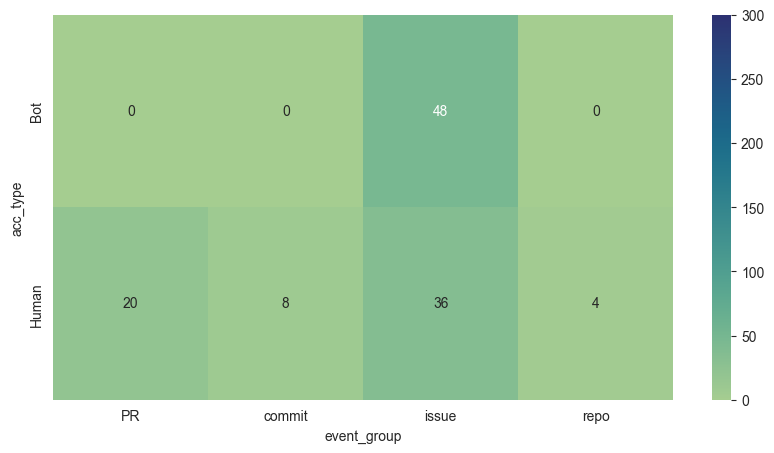

In [570]:
df_medians_pivot = df_medians.pivot(index='acc_type', columns='event_group', values='median')
plt.figure(figsize=(10, 5))
sns.heatmap(df_medians_pivot, annot=True, vmin=0, vmax=300, cmap="crest")
plt.show()


#### What is the difference that you observe between Bots+Bot actors and Humans?

In [571]:
# Bots primarily interact with issues while humans have a more balanced distribution of events across issue, PR, commit, and repo.

#### What is the differnce that you observe between Event groups?

In [572]:
# Issue events have the highest number of events for both humans and bots.

#### What is the difference that you observe between Bots+Bot actors and Humans and Event groups all considering at the same time?

In [573]:
# Bots have a higher number of events in the issue event group compared to humans, while humans have a more balanced distribution of events across all event groups.

### Question 3

#### Create boxen plots to visualise the distribution of number of events in each event group. 
#### For more information you can visit - https://seaborn.pydata.org/generated/seaborn.boxenplot.html#seaborn.boxenplot 
#### You should highlight the data points that correspond to bots using a stripplot in seaborn. https://seaborn.pydata.org/tutorial/categorical.html#categorical-tutorial  
#### Interpret the results of the visualisation.

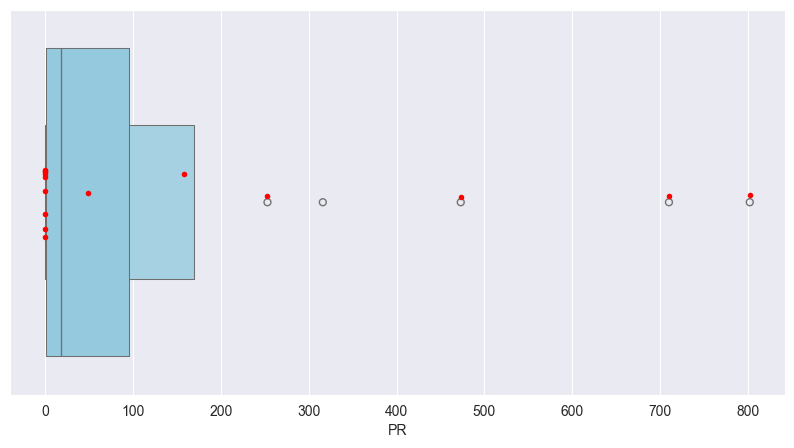

In [574]:
# YOUR CODE BELOW - Visualize number of events from pull request event group

plt.figure(figsize=(10, 5))
sns.boxenplot(x='PR', data=df_groupby, color='skyblue')
sns.stripplot(x='PR', data=df_groupby[df_groupby['acc_type'] == 'Bot'], color='red', size=4)
plt.show()

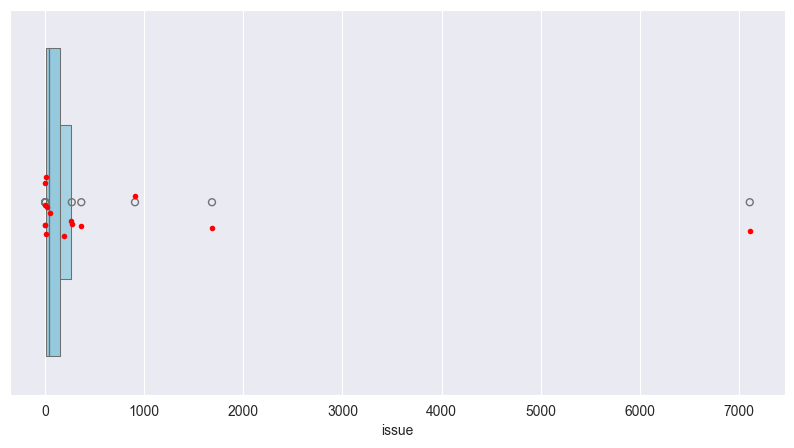

In [575]:
# YOUR CODE BELOW - Visualise number of events from issue event group
plt.figure(figsize=(10, 5))
sns.boxenplot(x='issue', data=df_groupby, color='skyblue')
sns.stripplot(x='issue', data=df_groupby[df_groupby['acc_type'] == 'Bot'], color='red', size=4)
plt.show()

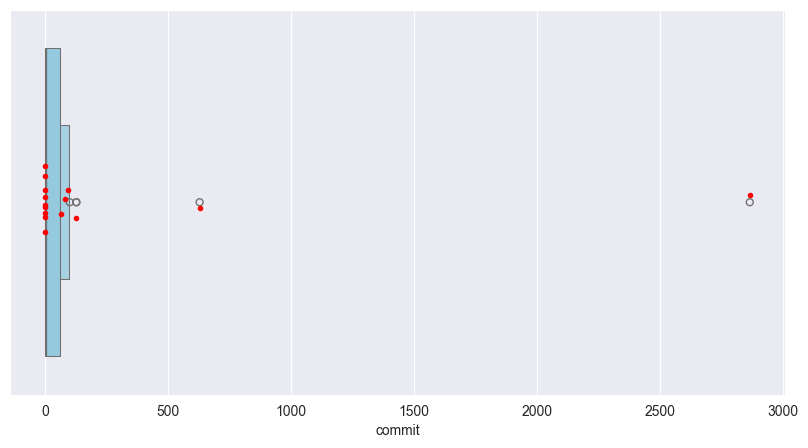

In [576]:
# YOUR CODE BELOW - Visualise number of events from commit event group
plt.figure(figsize=(10, 5))
sns.boxenplot(x='commit', data=df_groupby, color='skyblue')
sns.stripplot(x='commit', data=df_groupby[df_groupby['acc_type'] == 'Bot'], color='red', size=4)
plt.show()

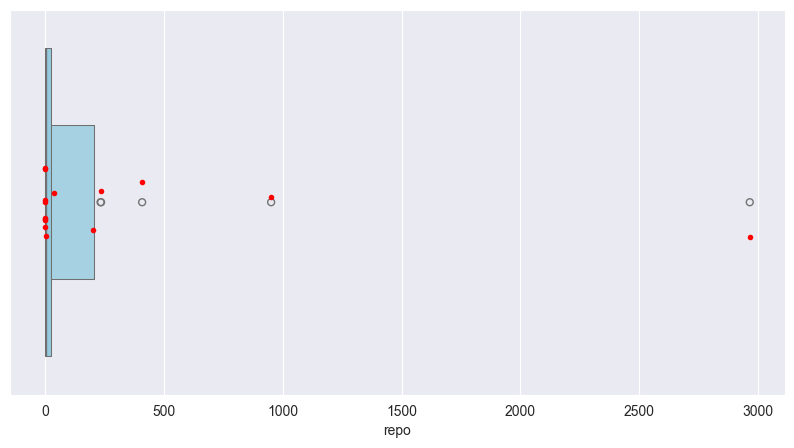

In [577]:
# YOUR CODE BELOW - Visualise number of events from repo event group
plt.figure(figsize=(10, 5))
sns.boxenplot(x='repo', data=df_groupby, color='skyblue')
sns.stripplot(x='repo', data=df_groupby[df_groupby['acc_type'] == 'Bot'], color='red', size=4)
plt.show()

### Question 4.1

#### Statistical identify whether number of events in each event group is normally distributed or not.
#### Null hypothesis - $H_0$: Sample comes from the data that has normal distribution.
#### Use Shapiro-Wilk test for this purpose. Use the p-value with a threshold of 0.05 to determine whether $H_0$ can be rejected with statistical significance or not. 

#### Use shapiro from scipy.stats to perform this test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html)

In [578]:
shapiro_results = {}
for event_group in ['issue', 'PR', 'commit', 'repo']:
    shapiro_results[event_group] = shapiro(df_groupby[event_group])
shapiro_results

{'issue': ShapiroResult(statistic=np.float64(0.2662896954878775), pvalue=np.float64(6.882456910464553e-13)),
 'PR': ShapiroResult(statistic=np.float64(0.5619508941268013), pvalue=np.float64(9.807488789584887e-10)),
 'commit': ShapiroResult(statistic=np.float64(0.24373733136569264), pvalue=np.float64(4.335509370075749e-13)),
 'repo': ShapiroResult(statistic=np.float64(0.2900761278320768), pvalue=np.float64(1.133076250337676e-12))}

In [579]:
null_hypo_threshold = 0.05
for event_group, result in shapiro_results.items():
    if result.pvalue < null_hypo_threshold:
        print(f"Null hypothesis rejected for {event_group} event group. p-value: {result.pvalue}. Data is not normally distributed.")
    else:
        print(f"Null hypothesis not rejected for {event_group} event group. p-value: {result.pvalue}. Data is normally distributed.")

Null hypothesis rejected for issue event group. p-value: 6.882456910464553e-13. Data is not normally distributed.
Null hypothesis rejected for PR event group. p-value: 9.807488789584887e-10. Data is not normally distributed.
Null hypothesis rejected for commit event group. p-value: 4.335509370075749e-13. Data is not normally distributed.
Null hypothesis rejected for repo event group. p-value: 1.133076250337676e-12. Data is not normally distributed.


### Question 4.2
#### Determine if there is any statistical diﬀerence in number of events between the identified event groups. Perform this test on all pairs of event groups. 
#### Null hypothesis - $H_0$: Any two event group come from the same population.
#### If $H_0$ is rejected in Shapiro-Wilk test (at least for one of the two event groups considered for test), use the Mann-Whitney U statistical test for this purpose. If $H_0$ is not rejected in Shapiro-Wilk test, use the independent t-test for this purpose.  
#### In any case, use the p-value with a threshold of 0.01 to determine whether $H_0$ can be rejected with statistical significance. 

#### Use mannwhitneyu from scipy.stats to perform Mann-Whitney U test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mannwhitneyu.html) 
#### or 
#### ttest_ind from scipy.stats to perform independent t-test https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html.

#### More information:

You can pass the following arguments to mannwhitneyu from scipy.stats - (method='exact', nan_policy='omit'). For ttest_ind you can use - (nan_policy='omit')

In [580]:
null_hypo_threshold = 0.01
mannwhitneyu_results = {}
ttest_results = {}
for i in range(len(['issue', 'PR', 'commit', 'repo'])):
    for j in range(i+1, len(['issue', 'PR', 'commit', 'repo'])):
        event_group1 = ['issue', 'PR', 'commit', 'repo'][i]
        event_group2 = ['issue', 'PR', 'commit', 'repo'][j]
        if shapiro_results[event_group1].pvalue < null_hypo_threshold or shapiro_results[event_group2].pvalue < null_hypo_threshold:
            mannwhitneyu_results[(event_group1, event_group2)] = mannwhitneyu(df_groupby[event_group1], df_groupby[event_group2], method='exact', nan_policy='omit')
        else:
            ttest_results[(event_group1, event_group2)] = ttest_ind(df_groupby[event_group1], df_groupby[event_group2], nan_policy='omit')
print("Mann-Whitney U Test Results:")
if mannwhitneyu_results:
    for key in mannwhitneyu_results:
        if mannwhitneyu_results[key].pvalue < null_hypo_threshold:
            print(f"Null hypothesis rejected for {key}. p-value: {mannwhitneyu_results[key].pvalue}. There is a statistical difference between the two event groups.")
        else:
            print(f"Null hypothesis not rejected for {key}. p-value: {mannwhitneyu_results[key].pvalue}. There is no statistical difference between the two event groups.")
else:
    print("No Mann-Whitney U Test Results.")

print("\nIndependent T-Test Results:")
if ttest_results:
    for key in ttest_results:
        if ttest_results[key].pvalue < null_hypo_threshold:
            print(f"Null hypothesis rejected for {key}. p-value: {ttest_results[key].pvalue}. There is a statistical difference between the two event groups.")
        else:
            print(f"Null hypothesis not rejected for {key}. p-value: {ttest_results[key].pvalue}. There is no statistical difference between the two event groups.")
else:
    print("No Independent T-Test Results.")

Mann-Whitney U Test Results:
Null hypothesis not rejected for ('issue', 'PR'). p-value: 0.14028311645020816. There is no statistical difference between the two event groups.
Null hypothesis rejected for ('issue', 'commit'). p-value: 0.004769383387728781. There is a statistical difference between the two event groups.
Null hypothesis rejected for ('issue', 'repo'). p-value: 0.0004430739331183868. There is a statistical difference between the two event groups.
Null hypothesis not rejected for ('PR', 'commit'). p-value: 0.15100214343118015. There is no statistical difference between the two event groups.
Null hypothesis not rejected for ('PR', 'repo'). p-value: 0.08589686714469841. There is no statistical difference between the two event groups.
Null hypothesis not rejected for ('commit', 'repo'). p-value: 0.7196786838566284. There is no statistical difference between the two event groups.

Independent T-Test Results:
No Independent T-Test Results.


### Question 4.3
#### Each time you reject the null hypothesis $H_0$, quantify the effect size of the diﬀerence between the groups using cliﬀ’s delta ($\delta$). 
#### To calculate cliﬀ’s delta, you can pass the list of values to cliﬀ delta.py file given in the repository. E.g., cliffsDelta.cliffsDelta(list of values, list of values). This will return the effect size.
#### Refer to the table given in the TP document and mention your interpretation (negligible, small, medium, large).

In [581]:
cliffs_delta = {}
if mannwhitneyu_results:
    for key in mannwhitneyu_results:
        cliffs_delta[key] = cd.cliffsDelta(df_groupby[key[0]], df_groupby[key[1]])
if ttest_results:
    for key in ttest_results:
        cliffs_delta[key] = cd.cliffsDelta(df_groupby[key[0]], df_groupby[key[1]])
for key in cliffs_delta:
    print(f"Cliff's Delta for {key}: {cliffs_delta[key]}")
    if cliffs_delta[key] < 0.147:
        print("Effect Size: Negligible")
    elif cliffs_delta[key] < 0.33:
        print("Effect Size: Small")
    elif cliffs_delta[key] < 0.474:
        print("Effect Size: Medium")
    else:
        print("Effect Size: Large")

Cliff's Delta for ('issue', 'PR'): 0.193125
Effect Size: Small
Cliff's Delta for ('issue', 'commit'): 0.36375
Effect Size: Medium
Cliff's Delta for ('issue', 'repo'): 0.449375
Effect Size: Medium
Cliff's Delta for ('PR', 'commit'): 0.1875
Effect Size: Small
Cliff's Delta for ('PR', 'repo'): 0.224375
Effect Size: Small
Cliff's Delta for ('commit', 'repo'): 0.048125
Effect Size: Negligible
